In [1]:
# import required packages
# source: https://www.kaggle.com/allunia/patterns-of-colorectal-cancer-wally

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='darkgrid')

# Import classifiers used:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

# Data Transformation
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer


# Import ovo and ovr related stuff
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import VotingClassifier

# Pre-processing Data:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict, GridSearchCV

# Import Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix, plot_roc_curve

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Optimize HP
from evolutionary_search import EvolutionaryAlgorithmSearchCV

In [2]:
import time 
import functools

def timer(func):
    """Prints the runtime of the decorate function"""
    @functools.wraps(func)
    def wrapper_time(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        run_time = time.perf_counter() - start_time
        print(f'Finished in {run_time:.4f} secs')
        return value
    return wrapper_time


In [3]:
# Ensure that GPU is detected
assert(tf.config.experimental.list_physical_devices('GPU') is not None), 'GPU not detected'
print('GPU Detected. TF good to go')

GPU Detected. TF good to go


In [4]:
df = pd.read_csv('../01_Data_Files/hmnist_64_64_L.csv', engine='c') # read 64x64 gray scale images as csv

dict_class_names = {1: 'Tumor', 2:'Stroma', 3:'Complex', 4:'Lymphoma', 5:'Debris', 6:'Mucosa', 7:'Adipose', 8:'Empty'}
df['label_name'] = df['label'].map(dict_class_names)
class_names = ['Tumor', 'Stroma', 'Complex', 'Lymphoma', 'Debris', 'Mucosa', 'Adipose', 'Empty']

In [5]:
train, val = train_test_split(df, test_size=0.1, stratify=df.label.values, random_state=42)
train, test = train_test_split(train, test_size=0.1, stratify=train.label.values, random_state=42)


In [5]:
label_counts = pd.DataFrame(index=np.arange(1,9), columns=['train', 'validate', 'test'])
label_counts['train'] = train['label'].value_counts().sort_index()
label_counts['validate'] = val['label'].value_counts().sort_index()
label_counts['test'] = test['label'].value_counts().sort_index()

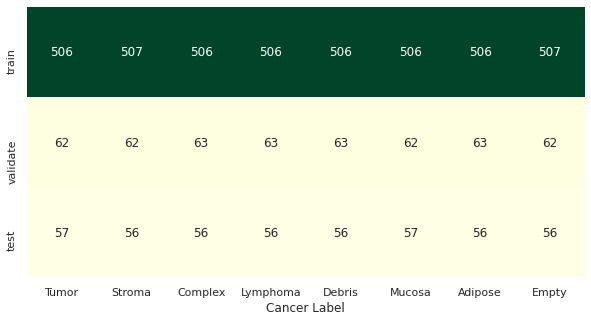

In [6]:
plt.figure(figsize=(10,5))
sns.heatmap(label_counts.transpose(), cmap='YlGn', annot=True, fmt='g', cbar=False, xticklabels=class_names)
plt.xlabel('Cancer Label')
plt.savefig('test_validation_training_intial_distribution.png')

In [51]:
# Encode labels into binary form for easier recognition later. 
encoder = OneHotEncoder(sparse=False)

# Set training, validation and testing x, y values 

X_train = train.drop(['label', 'label_name'], axis=1).values
y_train = encoder.fit_transform(train['label_name'].values.reshape(-1,1))

X_validate = val.drop(['label', 'label_name'], axis=1).values
y_validate = encoder.transform(val['label_name'].values.reshape(-1,1))

X_test = test.drop(['label', 'label_name'], axis=1).values
y_test = encoder.transform(test['label_name'].values.reshape(-1,1))

In [7]:
# Important Sanity Checks:

# Ensure the lengths of the training, test and validation x and y match. 
assert len(X_train) == len(y_train), 'Training Len Mismatch'
assert len(X_validate) == len(y_validate), 'Validate Len Mismatch'
assert len(X_test)  == len(y_test), 'Test Len Msimatch'

In [8]:
# Use min max scaler to set the values of Xs to between 0 and 1. 
# We know that our input can vary between 0 and 255
min_max_scaler = MinMaxScaler()

# Create a fake array with values between 0 and 255 to use for fitting min max scaler
scaling_array = np.append(
    [np.zeros_like(X_train[0], dtype=np.int16)], [np.full_like(X_train[0], 255, dtype=np.int16)], axis=0
)
min_max_scaler.fit(scaling_array)
X_train_scaled = min_max_scaler.transform(X_train)
X_validate_scaled = min_max_scaler.transform(X_validate)
X_test_scaled = min_max_scaler.transform(X_test)

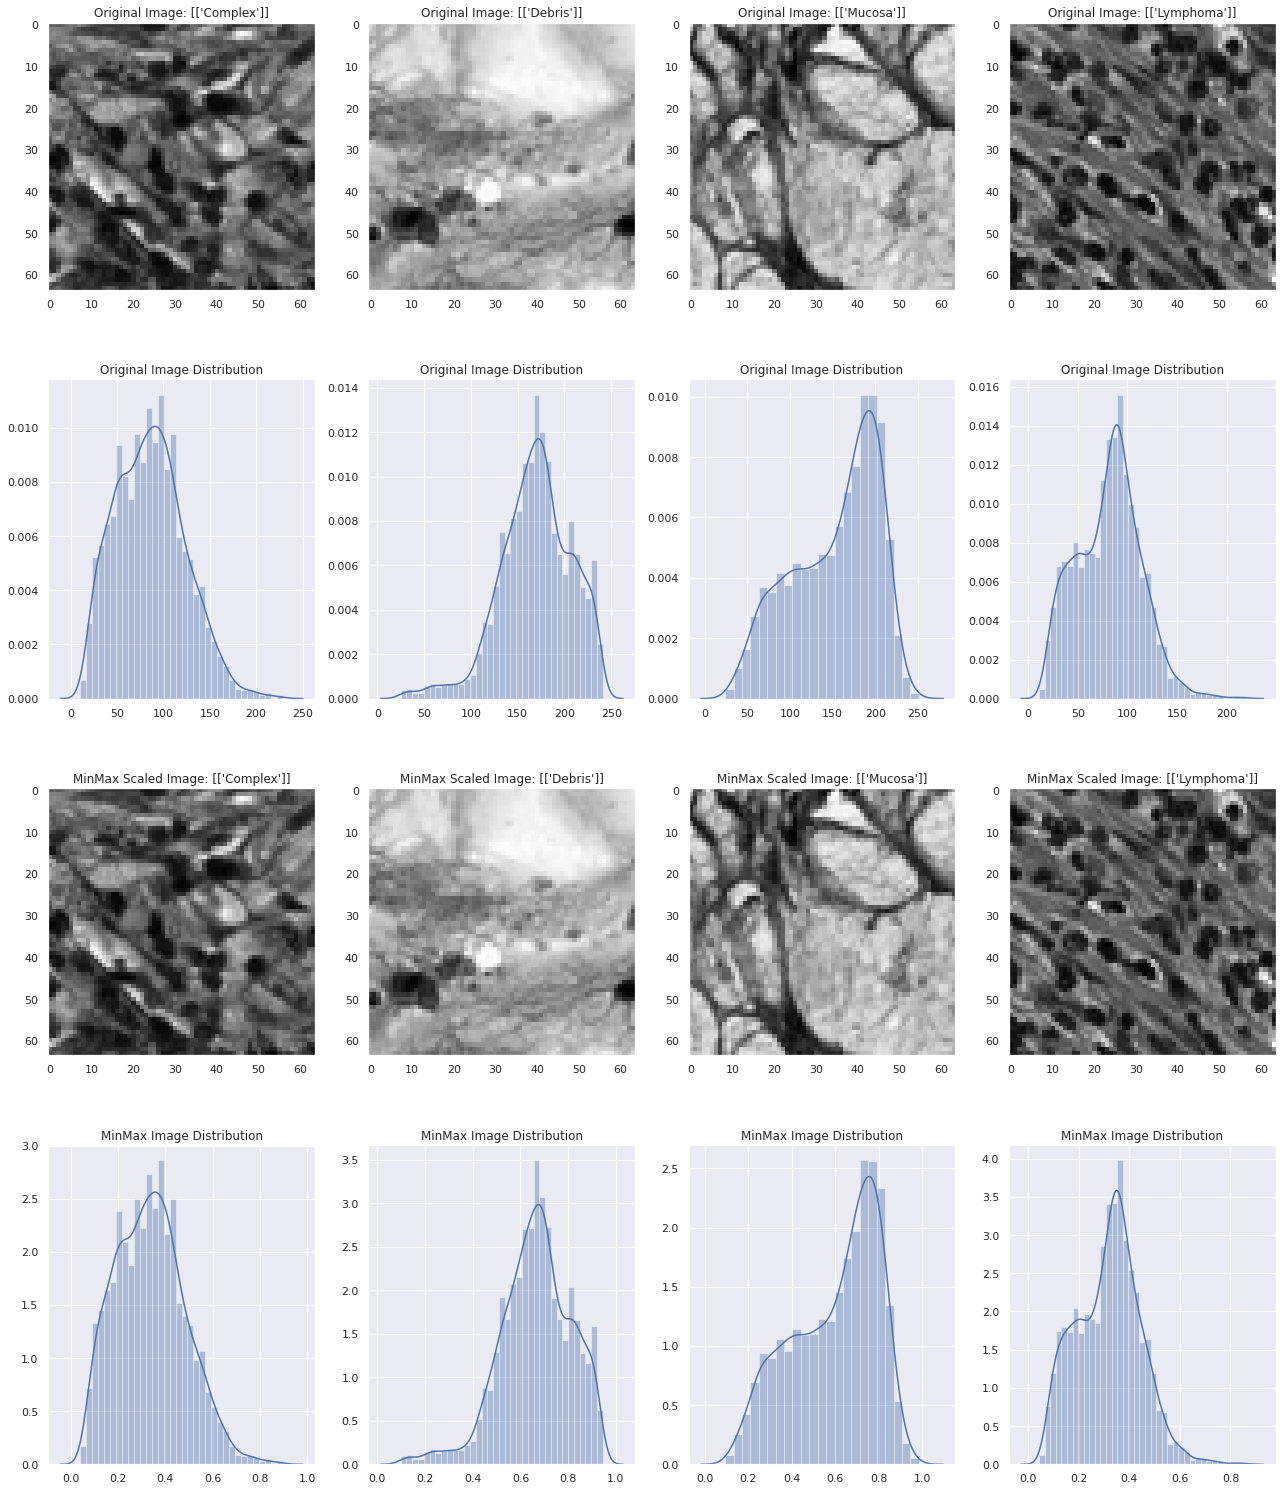

In [10]:
# Lets make sure that that distribution of our data hasn't changed significantly due to scaling. 
# Mostly a sanity check
fig, axs = plt.subplots(4, 4, figsize=(22,27))
for i in range(4):

    # Show Original Images
    original_image = np.reshape(X_train[i], (64,64))
    axs[0,i].imshow(original_image, cmap='gray')
    label_image = encoder.inverse_transform([y_train[i]])
    axs[0,i].set_title(f'Original Image: {label_image}')
    axs[0,i].grid(False)

    # Show histogram of values in image:
    sns.distplot(original_image, ax=axs[1,i])
    axs[1,i].set_title('Original Image Distribution')
    axs[1,i].set_ylabel('')

    # Show Scaled Images:
    scaled_image = np.reshape(X_train_scaled[i], (64,64))
    axs[2,i].imshow(scaled_image, cmap='gray')
    label_image = encoder.inverse_transform([y_train[i]])
    axs[2,i].set_title(f'MinMax Scaled Image: {label_image}')
    axs[2,i].grid(False)

    # Show histogram of values in image:
    sns.distplot(scaled_image, ax=axs[3,i])
    axs[3,i].set_title('MinMax Image Distribution')
    axs[3,i].set_ylabel('')

plt.savefig('Image Distributions.png')


## Test Classifiers

In [ ]:
classifier_score_dict = {}

# Overall
f1_scores = {}
accuracy_scores = {}

recall_scores = {}
precision_scores = {}

In [14]:
# Convolutional Neural Network:
# Architecture: Input - Conv2D, Conv 2D, Conv2D, Flatten, Dense, Dense, Dense - Output
# Source: https://www.kaggle.com/efeergun96/colorectal-histology-prediction-by-cnn

cnn_model = Sequential()

cnn_model.add(Reshape(
    target_shape= (64,64,1), 
    input_shape = (4096,),
))

cnn_model.add(Conv2D(
    filters = 128, 
    kernel_size = (5,5), 
    padding = 'same',
    activation = 'relu' 
))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    padding='same',
    activation='relu'
))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    padding='same',
    activation='relu'
))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())

cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(32, activation='relu'))

cnn_model.add(Dense(8, activation='softmax'))

cnn_model.compile(optimizer = "Adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = cnn_model.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=20,
    validation_data= (X_validate_scaled, y_validate),
    verbose=1,
)

Epoch 1/20
127/127 [==============================] - 1s 9ms/step - loss: 0.9154 - accuracy: 0.6412 - val_loss: 0.8535 - val_accuracy: 0.6880
Epoch 2/20
127/127 [==============================] - 1s 8ms/step - loss: 0.7893 - accuracy: 0.6741 - val_loss: 0.8912 - val_accuracy: 0.6400
Epoch 3/20
127/127 [==============================] - 1s 8ms/step - loss: 0.8403 - accuracy: 0.6585 - val_loss: 0.8490 - val_accuracy: 0.6420
Epoch 4/20
127/127 [==============================] - 1s 9ms/step - loss: 0.6924 - accuracy: 0.7262 - val_loss: 0.6919 - val_accuracy: 0.7100
Epoch 5/20
127/127 [==============================] - 1s 9ms/step - loss: 0.6512 - accuracy: 0.7486 - val_loss: 1.2467 - val_accuracy: 0.5500
Epoch 6/20
127/127 [==============================] - 1s 9ms/step - loss: 0.6841 - accuracy: 0.7319 - val_loss: 0.8091 - val_accuracy: 0.6820
Epoch 7/20
127/127 [==============================] - 1s 9ms/step - loss: 0.5500 - accuracy: 0.7844 - val_loss: 0.6574 - val_accuracy: 0.7440
Epoch 

15/15 - 0s - loss: 0.7639 - accuracy: 0.7822


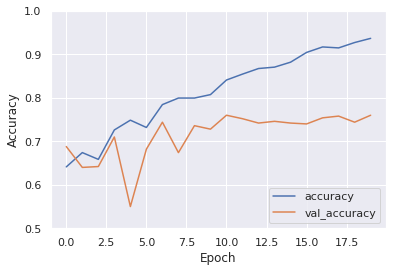

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(X_test_scaled,  y_test, verbose=2)

In [61]:
y_pred_cnn = cnn_model.predict(X_test_scaled)
y_pred_cnn = encoder.inverse_transform(y_pred_cnn)
y_test_cnn = encoder.inverse_transform(y_test)

# confusion_matrix(y_test_cnn, y_pred_cnn)

In [64]:
confusion_matrix(y_test_cnn, y_pred_cnn)

array([[48,  0,  2,  6,  0,  0,  0,  0],
       [ 0, 38,  5,  0,  1,  5,  3,  4],
       [ 3,  1, 42,  0,  0,  4,  6,  0],
       [ 2,  0,  0, 54,  0,  0,  0,  0],
       [ 0, 12,  0,  0, 43,  0,  0,  1],
       [ 0,  3,  1,  0,  1, 50,  0,  2],
       [ 0, 12, 13,  0,  0,  2, 26,  3],
       [ 0,  3,  2,  0,  0,  1,  0, 51]])

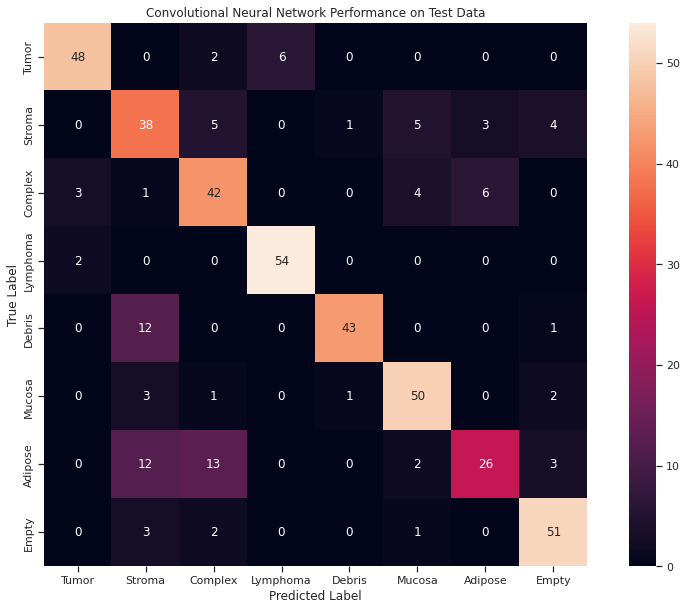

In [82]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test_cnn, y_pred_cnn), annot=True, fmt='d', ax=ax, xticklabels=class_names, yticklabels=class_names, square=True)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True, left=True, labelleft=True)
plt.yticks(va='center')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Convolutional Neural Network Performance on Test Data')
plt.savefig('cnn_test_confusion_matrix')

In [63]:
print(classification_report(y_test_cnn, y_pred_cnn))

              precision    recall  f1-score   support

     Adipose       0.91      0.86      0.88        56
     Complex       0.55      0.68      0.61        56
      Debris       0.65      0.75      0.69        56
       Empty       0.90      0.96      0.93        56
    Lymphoma       0.96      0.77      0.85        56
      Mucosa       0.81      0.88      0.84        57
      Stroma       0.74      0.46      0.57        56
       Tumor       0.84      0.89      0.86        57

    accuracy                           0.78       450
   macro avg       0.79      0.78      0.78       450
weighted avg       0.79      0.78      0.78       450



In [127]:
# Convert data into forms that is more acceptable for Sklearn library
# Previous forms were more suited for Tensorflow
# y_train = encoder.inverse_transform(y_train)
# y_validate = encoder.inverse_transform(y_validate)
# y_test = encoder.inverse_transform(y_test)

binarizer = LabelBinarizer()
binarizer.fit(y_train)

y_train_binarized = binarizer.transform(y_train)
y_test_binarized = binarizer.transform(y_test)
y_validate_binarized = binarizer.transform(y_validate)

# Creates dictionaries with class name and associated y_values for each of the test, val and train set. Can be used for training binary classifiers. 

y_train_dict_class = {class_name:y_train_binarized[:, i] for i,class_name in enumerate(binarizer.classes_) }
y_test_dict_class = {class_name:y_test_binarized[:, i] for i,class_name in enumerate(binarizer.classes_) }
y_validate_dict_class = {lass_name:y_validate_binarized[:, i] for i,class_name in enumerate(binarizer.classes_) }

In [128]:
y_train_dict_class

{'Adipose': array([0, 0, 0, ..., 0, 0, 0]),
 'Complex': array([1, 0, 0, ..., 0, 0, 0]),
 'Debris': array([0, 1, 0, ..., 1, 1, 0]),
 'Empty': array([0, 0, 0, ..., 0, 0, 0]),
 'Lymphoma': array([0, 0, 0, ..., 0, 0, 0]),
 'Mucosa': array([0, 0, 1, ..., 0, 0, 0]),
 'Stroma': array([0, 0, 0, ..., 0, 0, 0]),
 'Tumor': array([0, 0, 0, ..., 0, 0, 1])}

In [ ]:
# Create multi-class classifiers and save them to a list to be tested together. 
# Use default parameters to begin with. Only parameter to change would be n_jobs=-1 for parallel computation. 

knn_clf = KNeighborsClassifier() 

# Selected because it has the partial fit ability useful for updates with newer data. 
gaussiannb_clf = GaussianNB()

# 8 SVC classifiers that will then be combined into a voting with two different strategies, hard/ soft voting



multi_class_classifiers = []

